In [59]:
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import time

In [60]:
import ee 
import geemap

ee.Initialize(project="thurgau-irrigation")

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools

from src.et_blue_per_field.etc_look_up_processing import (
    add_date_column,
    compute_et_ratio_timeseries,
    plot_multiple_et_ratio_timeseries,
    create_et_mask,
)

from utils.ee_utils import (
    back_to_float,
    back_to_int,
    export_image_to_asset,
    print_value_ranges,
    is_image_empty,
    fill_gaps_with_zeros,
    export_feature_collection,
)


In [62]:
YEAR = 2021
ET_PRODUCT = "WaPOR_10m"
SCALING_FACTOR = 100

---

## Prepping the Validation data for eefication 
- Create monthly sum
- Create new FeatureCollection from blind data with monthly sum, then export to GEE


In [63]:
path_to_validation = (
    "/Users/cooper/Desktop/irrigation-mapper/data/HAFL_irri_Nov22_DataIrri.csv"
)

validation_raw = pd.read_csv(path_to_validation, sep=";", encoding="utf-8")


def calculate_monthly_sums(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate monthly sums of iri_val_mm for each ID
    """
    df = df.copy()
    df["Datum"] = pd.to_datetime(df["Datum"])

    df["month"] = df["Datum"].dt.month
    df["year"] = df["Datum"].dt.year

    # Group by ID and month, sum iri_val_mm
    monthly_sums = df.groupby(["ID", "month", "year"])["iri_val_mm"].sum().reset_index()
    monthly_sums["iri_val_m3/ha"] = monthly_sums["iri_val_mm"] * 10

    return monthly_sums


validation_monthly_sums = calculate_monthly_sums(validation_raw)
val_2018 = validation_monthly_sums[validation_monthly_sums["year"] == 2018]
val_2019 = validation_monthly_sums[validation_monthly_sums["year"] == 2019]
val_2020 = validation_monthly_sums[validation_monthly_sums["year"] == 2020]
val_2021 = validation_monthly_sums[validation_monthly_sums["year"] == 2021]

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_16767/2877066858.py:13: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Datum"] = pd.to_datetime(df["Datum"])


In [64]:
def filter_collection_by_year(collection: ee.FeatureCollection, year: int) -> ee.FeatureCollection:
    """
    Filters a FeatureCollection to keep only features from a specific year based on ID prefix.
    
    Args:
        collection: Input FeatureCollection where features have IDs starting with year
        year: Four-digit year (e.g., 2021)
    
    Returns:
        ee.FeatureCollection containing only features from specified year
    """
    # Convert year to 2-digit string format
    year_prefix = str(year)[2:]
    
    # Filter collection based on ID prefix
    filtered = collection.filter(
        ee.Filter.stringStartsWith('ID', year_prefix)
    )
    
    return filtered

In [65]:
def create_irrigation_metrics_grid_multiyear(
    validation_dfs: dict[int, pd.DataFrame],
    years: list[int],
    etc_thresholds: list,
    min_irr_thresholds: list,
) -> pd.DataFrame:
    """
    Calculate irrigation metrics across years and thresholds, including overall metrics.

    Args:
        validation_dfs: Dict mapping years to validation DataFrames
        years: Years to analyze
        etc_thresholds: List of ETC thresholds to test
        min_irr_thresholds: List of minimum irrigation thresholds to test

    Returns:
        DataFrame with metrics for each year and overall metrics
    """
    metrics_list = []

    for etc, min_irr in itertools.product(etc_thresholds, min_irr_thresholds):
        # Initialize lists for overall metrics
        all_predictions = []
        all_actual = []

        # Calculate year-specific metrics
        for year in years:
            collection_path = f"projects/thurgau-irrigation/assets/FribourgAndVaud/ET_blue_per_field_v4/ET_blue_per_field_{year}_dekadal_from_{ET_PRODUCT}_ETC_{etc}_PRC50_min_irr_{min_irr}"
            feature_collection = ee.FeatureCollection(collection_path)
            feature_collection_year = filter_collection_by_year(
                feature_collection, year
            )

            features = feature_collection_year.toList(
                feature_collection_year.size()
            ).getInfo()

            predictions = []
            actual = []

            for feature in features:
                field_id = feature["properties"]["ID"]
                total_irrigation = sum(
                    feature["properties"].get(
                        f"filtered_et_blue_m3/ha_{year}_{month:02d}", 0
                    )
                    for month in range(5, 11)
                )
                predictions.append(1 if total_irrigation > 0 else 0)
                actual.append(1 if field_id in validation_dfs[year]["ID"].values else 0)

            # Add to overall lists
            all_predictions.extend(predictions)
            all_actual.extend(actual)

            # Calculate yearly metrics
            cm = confusion_matrix(actual, predictions)
            tn, fp, fn, tp = cm.ravel()

            metrics_list.append(
                {
                    "year": year,
                    "accuracy": (tp + tn) / (tp + tn + fp + fn),
                    "recall": tp / (tp + fn) if (tp + fn) > 0 else 0,
                    "etc_threshold": etc,
                    "minimum_irrigation_threshold": min_irr,
                }
            )

        # Calculate overall metrics
        cm_overall = confusion_matrix(all_actual, all_predictions)
        tn, fp, fn, tp = cm_overall.ravel()

        metrics_list.append(
            {
                "year": "overall", 
                "accuracy": (tp + tn) / (tp + tn + fp + fn),
                "recall": tp / (tp + fn) if (tp + fn) > 0 else 0,
                "etc_threshold": etc,
                "minimum_irrigation_threshold": min_irr,
            }
        )

    return pd.DataFrame(metrics_list)

In [113]:
def plot_irrigation_metrics_multiyear(metrics_df: pd.DataFrame) -> None:
    sns.set_context('talk')
    plt.figure(figsize=(6, 6))
    
    g = sns.scatterplot(
        data=metrics_df,
        x='recall',
        y='accuracy',
        hue='minimum_irrigation_threshold',
        palette='Set2',
        style='etc_threshold',
        s=150
    )
     
    sns.despine()
    plt.grid(linestyle='--', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [101]:
validation_dfs = {2018: val_2018, 2019: val_2019, 2020: val_2020, 2021: val_2021}
metrics_df = create_irrigation_metrics_grid_multiyear(
    validation_dfs,
    years=[2018, 2019, 2020, 2021],
    etc_thresholds=[70, 90],
    min_irr_thresholds=[50, 100, 140],
)

/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_16767/3648311796.py:25: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


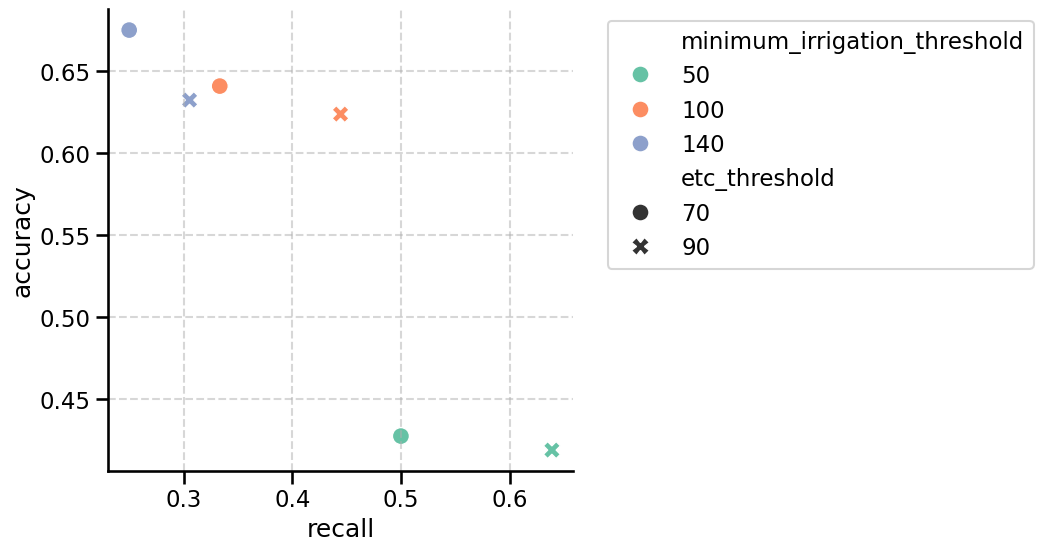

In [112]:
plot_irrigation_metrics_multiyear(metrics_df[metrics_df["year"] == "overall"])

In [10]:
# metrics_df

---

In [11]:
# def plot_irrigation_comparison(
#     feature_collection: ee.FeatureCollection,
#     validation_df: pd.DataFrame,
#     field_id: str,
#     year: int = 2018,
# ) -> None:
#     """
#     Plot monthly irrigation comparison between model predictions and validation data.

#     Args:
#         feature_collection: GEE FeatureCollection containing model predictions
#         validation_df: DataFrame with validation data
#         field_id: Field ID to plot
#         year: Year of analysis (default 2018)
#     """
#     # Extract feature for given field ID
#     field_feature = feature_collection.filter(ee.Filter.equals("ID", field_id)).first()

#     # Get all monthly predictions from feature
#     months = range(4, 11)  # April to October
#     predictions = []

#     for month in months:
#         prop_name = f"filtered_et_blue_m3/ha_{year}_{month:02d}"
#         value = field_feature.get(prop_name).getInfo()
#         predictions.append(value or 0)

#     # Get validation data for the field
#     field_validation = validation_df[validation_df["ID"] == field_id]

#     # Create array of validation values (0 if no data for month)
#     validation_values = []
#     for month in months:
#         val = field_validation[
#             (field_validation["month"] == month) & (field_validation["year"] == year)
#         ]["iri_val_m3/ha"].values
#         validation_values.append(val[0] if len(val) > 0 else 0)

#     # Create bar plot
#     months_str = ["Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct"]
#     x = range(len(months_str))
#     width = 0.35

#     fig, ax = plt.subplots(figsize=(10, 6))
#     ax.bar([i - width / 2 for i in x], predictions, width, label="Model")
#     ax.bar([i + width / 2 for i in x], validation_values, width, label="Validation")

#     ax.set_ylabel("Irrigation (m³/ha)")
#     ax.set_title(f"Monthly Irrigation Comparison - Field {field_id}")
#     ax.set_xticks(x)
#     ax.set_xticklabels(months_str)
#     ax.legend()
#     sns.despine()
#     plt.grid(axis="y", linestyle="--", alpha=0.6)

#     plt.tight_layout()
#     plt.show()


# for id in val_year["ID"].unique():
#     plot_irrigation_comparison(
#         feature_collection_year, val_year, id, year=YEAR
#     )

# # plot_irrigation_comparison(
# #     feature_collection_year, val_2018, "18-1-510465"
# # )

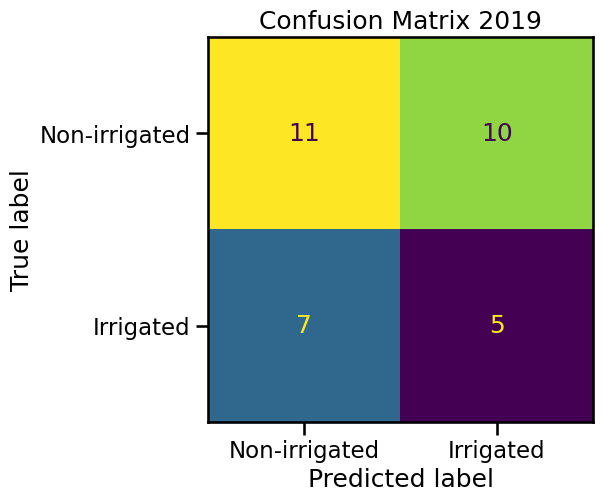


Metrics:
Accuracy: 0.485
Recall: 0.417


In [114]:
def create_irrigation_confusion_matrix(
    feature_collection: ee.FeatureCollection,
    validation_df: pd.DataFrame,
    year: int = 2019,
) -> None:
    """
    Create confusion matrix comparing predicted vs actual irrigation.
    Assumes fields not in validation_df are non-irrigated.
    """
    features = feature_collection.toList(feature_collection.size()).getInfo()
    predictions = []
    actual = []

    for feature in features:
        field_id = feature["properties"]["ID"]

        total_irrigation = sum(
            feature["properties"].get(f"filtered_et_blue_m3/ha_{year}_{month:02d}", 0)
            for month in range(5, 11)
        )
        predictions.append(1 if total_irrigation > 0 else 0)

        actual.append(1 if field_id in validation_df["ID"].values else 0)

    cm = confusion_matrix(actual, predictions)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=["Non-irrigated", "Irrigated"]
    )

    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, colorbar=False)
    plt.title(f"Confusion Matrix {year}")
    plt.show()

    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    # precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\nMetrics:")
    print(f"Accuracy: {accuracy:.3f}")
    # print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    # print(f"F1 Score: {f1:.3f}")


feature_collection = ee.FeatureCollection(
    "projects/thurgau-irrigation/assets/FribourgAndVaud/ET_blue_per_field_v4/ET_blue_per_field_2019_dekadal_from_WaPOR_10m_ETC_90_PRC50_min_irr_100"
)
feature_collection_year = filter_collection_by_year(feature_collection, 2019)

create_irrigation_confusion_matrix(feature_collection_year, val_2019, year=2019)

In [69]:
from typing import List, Dict


def get_broye_fields(year: int, options: Dict) -> ee.FeatureCollection:

    version = options["version"]
    et_product = options["et_product"]
    etc_threshold = options["etc_threshold"]
    min_irr_threshold = options["min_irr_threshold"]

    collection_path = f"projects/thurgau-irrigation/assets/FribourgAndVaud/ET_blue_per_field_{version}/ET_blue_per_field_{year}_dekadal_from_{et_product}_ETC_{etc_threshold}_PRC50_min_irr_{min_irr_threshold}"
    feature_collection = ee.FeatureCollection(collection_path)

    return feature_collection


def get_total_moitored_area(year: int, options: Dict) -> float:
    """Get total area of monitored fields."""
    fc = get_broye_fields(year, options)
    feature_collection_year = filter_collection_by_year(fc, year)
    features = feature_collection_year.toList(feature_collection_year.size()).getInfo()
    total_area = sum(
        ee.Feature(feature).geometry().area().getInfo() / 10000 for feature in features
    )
    return round(total_area, 2)


def get_irrigated_area(years: List[int], options: Dict) -> pd.DataFrame:
    """Extract irrigated fields and return their IDs and areas."""
    data = []

    for year in years:
        fc = get_broye_fields(year, options)
        feature_collection_year = filter_collection_by_year(fc, year)
        features = feature_collection_year.toList(
            feature_collection_year.size()
        ).getInfo()
        for feature in features:
            total_irrigation = sum(
                feature["properties"].get(
                    f"filtered_et_blue_m3/ha_{year}_{month:02d}", 0
                )
                for month in range(5, 11)
            )

            if total_irrigation > 0:
                area = ee.Feature(feature).geometry().area().getInfo() / 10000
                data.append(
                    {"ID": feature["properties"]["ID"], "area_ha": area, "year": year}
                )

    return pd.DataFrame(data)


def get_irrigated_area_from_validation(
    validation_data: Dict[int, pd.DataFrame], options: Dict
) -> pd.DataFrame:
    """Extract irrigated fields with their volumes and areas."""
    feature_collection = get_broye_fields(2018, options)  # Any year will do
    features = feature_collection.toList(feature_collection.size()).getInfo()
    data = []

    # Create area lookup dictionary
    area_lookup = {
        feature["properties"]["ID"]: ee.Feature(feature).geometry().area().getInfo()
        / 10000
        for feature in features
    }

    for year, df in validation_data.items():
        # Group by ID and sum volumes
        yearly_volumes = (
            df.groupby("ID")
            .agg({"iri_val_mm": "sum", "iri_val_m3/ha": "sum"})
            .reset_index()
        )

        # Add year and area
        for _, row in yearly_volumes.iterrows():
            field_id = row["ID"]
            data.append(
                {
                    "ID": field_id,
                    "year": year,
                    "area_ha": area_lookup.get(field_id, 0),
                    "volume_mm": row["iri_val_mm"],
                    "volume_m3_ha": row["iri_val_m3/ha"],
                }
            )

    return pd.DataFrame(data)

In [70]:
options = {
    "version": "v4",
    "et_product": "WaPOR_10m",
    "etc_threshold": 90,
    "min_irr_threshold": 100,
}

irrigated_model = get_irrigated_area(list(range(2018, 2022)), options)

print(irrigated_model.groupby("year")["area_ha"].sum())

irrigated_validation = get_irrigated_area_from_validation(validation_dfs, options)

print(irrigated_validation.groupby('year')['area_ha'].sum())

year
2018    34.985920
2019    51.940712
2020    24.548371
2021    11.997087
Name: area_ha, dtype: float64
year
2018    34.175642
2019    34.133593
2020    33.473066
2021    21.438397
Name: area_ha, dtype: float64


In [15]:
# for year in range(2018, 2022):
#     total_monitored = get_total_moitored_area(year, options)
#     print(f"Total monitored area in {year}: {total_monitored} ha")

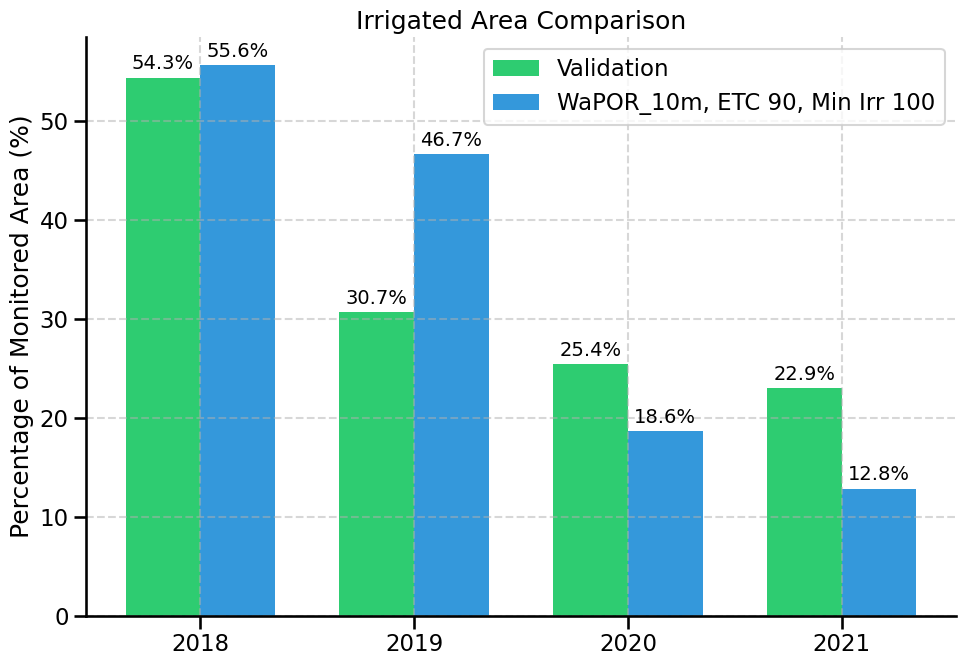

Mean Absolute Error: 8.54%


In [72]:
import numpy as np

sns.set_context("talk")
# Prepare data
years = range(2018, 2022)
monitored_areas = {2018: 62.89, 2019: 111.33, 2020: 131.80, 2021: 93.43}

validation_areas = irrigated_validation.groupby("year")["area_ha"].sum()
model_areas = irrigated_model.groupby("year")["area_ha"].sum()

# Calculate percentages
validation_percentages = [
    validation_areas[year] / monitored_areas[year] * 100 for year in years
]
model_percentages = [model_areas[year] / monitored_areas[year] * 100 for year in years]

# Set up the bar plot
width = 0.35
x = np.arange(len(years))

fig, ax = plt.subplots(figsize=(10, 7))
rects1 = ax.bar(
    x - width / 2, validation_percentages, width, label="Validation", color="#2ecc71"
)
rects2 = ax.bar(
    x + width / 2,
    model_percentages,
    width,
    label=f"{options['et_product']}, ETC {options['etc_threshold']}, Min Irr {options['min_irr_threshold']}",
    color="#3498db",
)

# Customize the plot
ax.set_ylabel("Percentage of Monitored Area (%)")
ax.set_xlabel("")
ax.set_title(f"Irrigated Area Comparison")
ax.set_xticks(x)
ax.set_xticklabels(years)
ax.legend()
plt.grid(linestyle='--', alpha=0.5)


# Add value labels on top of bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            f"{height:.1f}%",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=14,
        )


autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
sns.despine()

plt.show()

mae = np.mean(np.abs(np.array(validation_percentages) - np.array(model_percentages)))
print(f"Mean Absolute Error: {mae:.2f}%")

## ETfs thresholds

In [73]:
etc_table = ee.FeatureCollection("projects/thurgau-irrigation/assets/FribourgAndVaud/ETc_WAPOR/ETc_Pasture_Broye")

etc_df = geemap.ee_to_df(etc_table)

etc_df = add_date_column(etc_df)

etc_df["ETc"] = etc_df["ETc"]/10

print(etc_df.tail(12))

          ETc  Month  Year  dekade  Day       Date
204  0.160000      1  2023       3   21 2023-01-21
205  0.720000      2  2023       3   21 2023-02-21
206  1.200000      3  2023       3   21 2023-03-21
207  1.955000      4  2023       3   21 2023-04-21
208  3.275862      5  2023       3   21 2023-05-21
209  4.000000      6  2023       3   21 2023-06-21
210  4.079487      7  2023       3   21 2023-07-21
211  2.724242      8  2023       3   21 2023-08-21
212  2.095238      9  2023       3   21 2023-09-21
213  0.900000     10  2023       3   21 2023-10-21
214  0.300000     11  2023       3   21 2023-11-21
215  0.240000     12  2023       3   21 2023-12-21


In [74]:
PATH_TO_ETF = "projects/thurgau-irrigation/assets/FribourgAndVaud/ETF_Landsat/ETF_Pasture_dekadal_v2"

etf_collection = ee.ImageCollection(PATH_TO_ETF).map(
    lambda img: back_to_float(img, SCALING_FACTOR)
)

et_green_wapor = ee.ImageCollection(
    "projects/thurgau-irrigation/assets/FribourgAndVaud/ET_green/ET_green_dekadal_from_WaPOR_10m_v2"
).map(lambda img: back_to_float(img, SCALING_FACTOR))

In [75]:
wapor_et_ratio = compute_et_ratio_timeseries(
    et_collections=[et_green_wapor],#et_green_collection1 ,
    etc_df=etc_df,
    et_band_name="ET_green"
)

wapor_et_ratio

,date,et_ratio_1
0,2018-04-01,0.441176
1,2018-04-11,0.631373
2,2018-04-21,0.734403
3,2018-05-01,0.630978
4,2018-05-11,0.496656
...,...,...
79,2021-09-11,0.488250
80,2021-09-21,0.508421
81,2021-10-01,0.130769
82,2021-10-11,0.007692


In [77]:
from typing import List, Tuple
from datetime import datetime


def compute_etf_timeseries(
    etf_collections: List[ee.ImageCollection], 
    etf_band_name: str = "ETF"
) -> pd.DataFrame:
    collections_with_index = [
        collection.map(lambda img: img.set('collection_idx', i + 1))
        for i, collection in enumerate(etf_collections)
    ]
    
    merged = ee.ImageCollection(collections_with_index[0])
    for coll in collections_with_index[1:]:
        merged = merged.merge(coll)
        
    features = merged.map(
        lambda img: _process_single_etf_image(img, etf_band_name)
    ).sort('date')
    
    results = features.toList(features.size()).getInfo()
    return pd.DataFrame([feature['properties'] for feature in results]).sort_values('date')

def _process_single_etf_image(
    image: ee.Image, 
    etf_band_name: str = "ETF"
) -> ee.Feature:
    image_date = ee.Date(image.get('system:time_start'))
    collection_idx = image.get('collection_idx')
    
    valid_pixels = image.select(etf_band_name).unmask()
    
    combined_reducer = ee.Reducer.count().combine(
        ee.Reducer.median(), 
        sharedInputs=True
    )
    
    stats = valid_pixels.reduceRegion(
        reducer=combined_reducer,
        maxPixels=int(1e9)
    )
    
    count = ee.Number(stats.get(f"{etf_band_name}_count"))
    median = ee.Number(stats.get(f"{etf_band_name}_median"))
    
    return ee.Feature(None, {
        'date': image_date.format('YYYY-MM-dd'),
        'et_ratio_1': ee.Algorithms.If(count.gt(0), median, None)
    })

In [78]:
landsat_et_ratio = compute_etf_timeseries([etf_collection], etf_band_name="ET_green")

landsat_et_ratio

,date,et_ratio_1
0,2018-04-01,0.42
1,2018-04-11,0.00
2,2018-04-21,0.62
3,2018-05-01,0.00
4,2018-05-11,0.68
...,...,...
79,2021-09-11,0.00
80,2021-09-21,0.52
81,2021-10-01,0.61
82,2021-10-11,0.59


In [79]:
import matplotlib.dates as mdates

ETC_THRESHOLD = 0.7


def plot_dual_et_ratio_markers(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    labels: Tuple[str, str] = ("Collection 1", "Collection 2"),
) -> None:
    """Plot ET ratio time series for two collections using markers only, excluding 0 values.

    Args:
        df1: DataFrame for the first image collection.
        df2: DataFrame for the second image collection.
        labels: Tuple of labels for the two collections.
    """
    sns.set_context("talk")
    # Identify the ratio columns in each DataFrame
    ratio_col = "et_ratio_1"

    # Filter out 0 values
    df1_filtered = df1[df1[ratio_col] > 0]
    df2_filtered = df2[df2[ratio_col] > 0]

    plt.figure(figsize=(20, 6))

    # Plot filtered collections
    plt.scatter(
        df1_filtered["date"],
        df1_filtered[ratio_col],
        label=labels[0],
        marker="o",
        color="#3498db",
    )
    plt.scatter(
        df2_filtered["date"],
        df2_filtered[ratio_col],
        label=labels[1],
        marker="s",
        color="#e67e22",
    )

    plt.axhline(
        y=ETC_THRESHOLD, color="r", linestyle="--", alpha=0.5, label="Threshold"
    )

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    # plt.xticks(rotation=45)
    plt.title("Time Series of ET Ratios for Two Collections")
    plt.xlabel("")
    plt.ylabel("ET Fraction")
    plt.legend(loc="lower right")
    plt.grid(linestyle="--", alpha=0.5)
    sns.despine()
    plt.show()

In [85]:
import numpy as np

Kcs = ee.FeatureCollection(
    "projects/thurgau-irrigation/assets/FribourgAndVaud/ETc_WAPOR/Kc_Pasture_Broye_Aquastat"
)


def process_with_kc(
    ratio_df: pd.DataFrame, kc_collection: ee.FeatureCollection
) -> pd.DataFrame:
    # Convert dates once
    ratio_df["date"] = pd.to_datetime(ratio_df["date"])
    ratio_df["Month"] = ratio_df["date"].dt.month
    ratio_df["Decade"] = np.ceil(ratio_df["date"].dt.day / 10).astype(int)

    # Get all Kc values at once
    kc_values = kc_collection.map(
        lambda f: ee.Feature(
            None,
            {"Month": f.get("Month"), "Decade": f.get("Decade"), "Kc": f.get("Kc")},
        )
    ).getInfo()["features"]

    # Create lookup dictionary for faster access
    kc_lookup = {
        (f["properties"]["Month"], f["properties"]["Decade"]): f["properties"]["Kc"]
        for f in kc_values
    }

    # Apply Kc values using lookup
    ratio_df["Kc"] = ratio_df.apply(
        lambda row: kc_lookup.get((row["Month"], row["Decade"])), axis=1
    )

    # Calculate ETF
    ratio_df["et_ratio_1"] = ratio_df["et_ratio_1"] / ratio_df["Kc"]

    return ratio_df


# Usage
landsat_et_ratio = process_with_kc(landsat_et_ratio, Kcs)[["date", "et_ratio_1"]]

In [81]:
landsat_et_ratio

,date,et_ratio_1,Month,Decade,Kc
0,2018-04-01,0.494118,4,1,0.850000
1,2018-04-11,0.000000,4,2,0.850000
2,2018-04-21,0.729412,4,3,0.850000
3,2018-05-01,0.000000,5,1,0.851852
4,2018-05-11,0.798261,5,2,0.851852
...,...,...,...,...,...
79,2021-09-11,0.000000,9,2,0.952381
80,2021-09-21,0.546000,9,3,0.952381
81,2021-10-01,0.610000,10,1,1.000000
82,2021-10-11,0.590000,10,2,1.000000


In [82]:
wapor_et_ratio

,date,et_ratio_1
0,2018-04-01,0.441176
1,2018-04-11,0.631373
2,2018-04-21,0.734403
3,2018-05-01,0.630978
4,2018-05-11,0.496656
...,...,...
79,2021-09-11,0.488250
80,2021-09-21,0.508421
81,2021-10-01,0.130769
82,2021-10-11,0.007692


In [83]:
landsat_et_ratio

,date,et_ratio_1,Month,Decade,Kc
0,2018-04-01,0.494118,4,1,0.850000
1,2018-04-11,0.000000,4,2,0.850000
2,2018-04-21,0.729412,4,3,0.850000
3,2018-05-01,0.000000,5,1,0.851852
4,2018-05-11,0.798261,5,2,0.851852
...,...,...,...,...,...
79,2021-09-11,0.000000,9,2,0.952381
80,2021-09-21,0.546000,9,3,0.952381
81,2021-10-01,0.610000,10,1,1.000000
82,2021-10-11,0.590000,10,2,1.000000


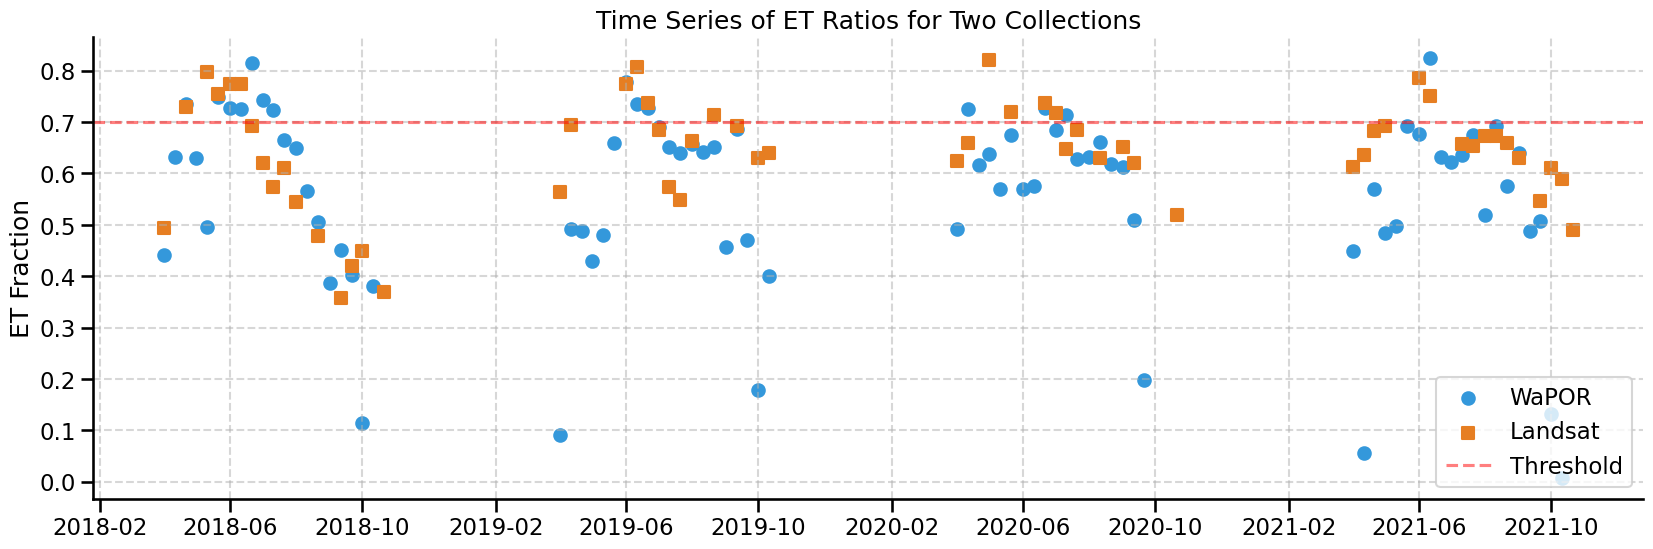

In [84]:
plot_dual_et_ratio_markers(wapor_et_ratio, landsat_et_ratio, labels=("WaPOR", "Landsat"))